In this notebook, we test the linear interpolation scheme using velocity and see if it leads to less number of messages to be transmit.

In [1]:
import numpy as np 
import pickle 
from matplotlib import pyplot as plt

with open('../trajectories.pyo', 'rb') as f:
    trajectories = pickle.load(f)

t_vec = np.array(trajectories['t_vec'])
y_vec = np.array(trajectories['y_vec'])
x_vec = trajectories['x_vec']

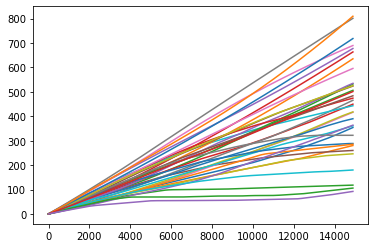

In [2]:
for i in range(35):
    plt.plot(t_vec, y_vec[i,:], label='y')

Subtracting each trajectory in the dataset from the mean trajectory

Calculate the mean trajectory and velocity:

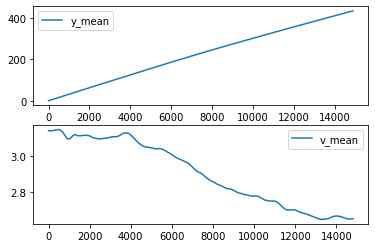

In [3]:
# Calculate the mean of the trajectories
y_mean = np.mean(y_vec, axis=0)
yv_mean = np.diff(y_mean)
plt.subplot(2,1,1)
plt.plot(t_vec, y_mean, label='y_mean')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t_vec[:t_vec.shape[0]-1], yv_mean, label='v_mean')
plt.legend()

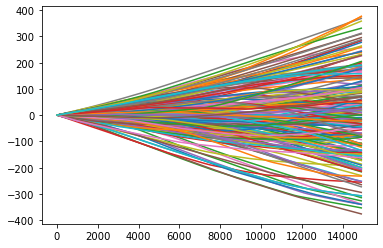

In [4]:
yz_vec = np.copy(y_vec)
for i in range(y_vec.shape[0]):
    yz_vec[i,:] = y_vec[i,:] - y_mean
    plt.plot(t_vec, yz_vec[i,:], label='yz')

Let's use linear extrapolation over the residual trajectory for prediction on the client side 

In [42]:
def test(traj_id):
    client_y = np.zeros((t_vec.shape[0],))
    ego_y = y_vec[traj_id,:]
    client_v = np.zeros_like(client_y)
    y_last = ego_y[0]
    yz_last = y_last - y_mean[0]
    i_last = 0
    v_last = ego_y[1] - ego_y[0]
    vz_last = v_last - yv_mean[0]
    rebroadcasts = 0
    for i in range(t_vec.shape[0]-1):
        # Make a prediction on the ego side
        yz_hat = yz_last + vz_last * (i - i_last)
        y_hat = yz_hat + y_mean[i]
        if np.abs(y_hat - ego_y[i])>3:
            # Trigger rebroadcast 
            rebroadcasts += 1
            client_y[i] = ego_y[i] # for logging purpose only
            v_last = ego_y[i] - ego_y[i-1] 
            vz_last = v_last - yv_mean[i] # transmit to client
            i_last = i
            y_last = ego_y[i] 
            yz_last = y_last - y_mean[i] # transmit to client
            client_v[i] = yv_mean[i] + vz_last # for logging purpose only
        else:
            client_y[i] = y_hat
            client_v[i] = v_last

    return rebroadcasts, client_y, client_v

In [43]:
rebroadcast_log = np.zeros((y_vec.shape[0],))
for i in range(y_vec.shape[0]):
    rebroadcasts, client_y, client_v = test(i)
    rebroadcast_log[i] = rebroadcasts

(array([ 1.,  0.,  4.,  0., 13.,  0., 34.,  0., 44.,  0.,  0., 48.,  0.,
        36.,  0., 12.,  0.,  6.,  0.,  2.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ]),
 <BarContainer object of 20 artists>)

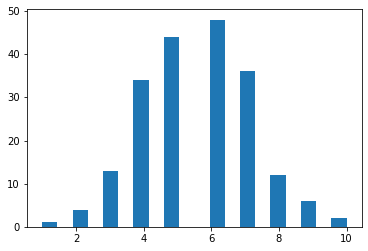

In [44]:
plt.hist(rebroadcast_log, bins=20)

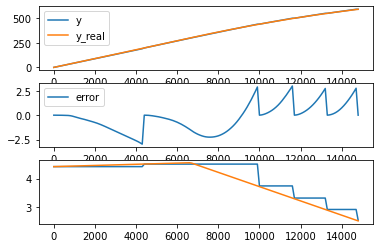

In [50]:
ego_y = y_vec[-1,:]
ego_yv = np.diff(ego_y)
plt.subplot(3,1,1)
plt.plot(t_vec[:-1], client_y[:-1], label='y')
plt.plot(t_vec[:-1], ego_y[:-1], label='y_real')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t_vec[:-1], client_y[:-1] - ego_y[:-1], label='error')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t_vec[:-1], client_v[:-1], label='v')
plt.plot(t_vec[:-1], ego_yv, label='v_real')

In [48]:
print('Mean: ', np.mean(rebroadcast_log))
print('Std: ', np.std(rebroadcast_log))

Mean:  5.57
Std:  1.6109314076024466
